In [1]:
!pip3 install scikit-learn

You should consider upgrading via the '/Volumes/Kerja_Keras/Folder_Fold_Recovery/For Learning/Bootcamp Binar/GoldChallange_Binar/gold_binar/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [3]:
btc = yf.download('BTC-USD', start='2010-01-01')
gold = yf.download('GC=F',start = '2010-01-01')
sp500 = yf.download('^GSPC', start='2010-01-01')
nasdaq = yf.download('^IXIC', start='2010-01-01')
usm2 = pd.read_csv("M2SL.csv")

usm2['DATE'] = pd.to_datetime(usm2['DATE'])
usm2 = usm2.set_index('DATE')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
df = pd.concat([btc['Adj Close'], gold['Adj Close'], sp500['Adj Close'], nasdaq['Adj Close']], axis=1)
df = pd.concat([df,usm2['M2SL']],axis=1)
df.columns = ['BTC', 'Gold', 'S&P500', 'NASDAQ','M2SL']

In [5]:
df.dropna(inplace = True)

In [6]:
df

,BTC,Gold,S&P500,NASDAQ,M2SL
2014-10-01,383.614990,1214.599976,1946.160034,4422.089844,11566.0
2014-12-01,379.244995,1218.000000,2053.439941,4727.350098,11684.9
2015-04-01,247.272003,1208.099976,2059.689941,4880.229980,11928.9
2015-05-01,232.078995,1174.500000,2108.290039,5005.390137,11957.9
2015-06-01,222.925995,1188.300049,2111.729980,5082.930176,12001.7
...,...,...,...,...,...
2022-09-01,20127.140625,1696.599976,3966.850098,11785.129883,21523.1
2022-11-01,20485.273438,1645.000000,3856.100098,10890.849609,21396.9
2022-12-01,16967.132812,1801.099976,4076.570068,11482.450195,21357.7
2023-02-01,23723.769531,1927.800049,4119.209961,11816.320312,21075.4


In [7]:
perubahan_btc = ((df['BTC'][-1]-df['BTC'][0])/df['BTC'][0])*100
perubahan_gold = ((df['Gold'][-1]-df['Gold'][0])/df['Gold'][0])*100
perubahan_sp500 = ((df['S&P500'][-1]-df['S&P500'][0])/df['S&P500'][0])*100
perubahan_nasdaq = ((df['NASDAQ'][-1]-df['NASDAQ'][0])/df['NASDAQ'][0])*100
perubahan_M2SL = ((df['M2SL'][-1]-df['M2SL'][0])/usm2['M2SL'][0])*100

In [8]:
list_Asset = ['BTC','GOLD','SP500','NASDAQ','M2SL']
nilai_perubahan = [perubahan_btc,perubahan_gold,perubahan_sp500,perubahan_nasdaq,perubahan_M2SL]

Text(0, 0.5, 'Presentase Perubahan % \n Since 2014-10-01 until 2023-03-01 ')

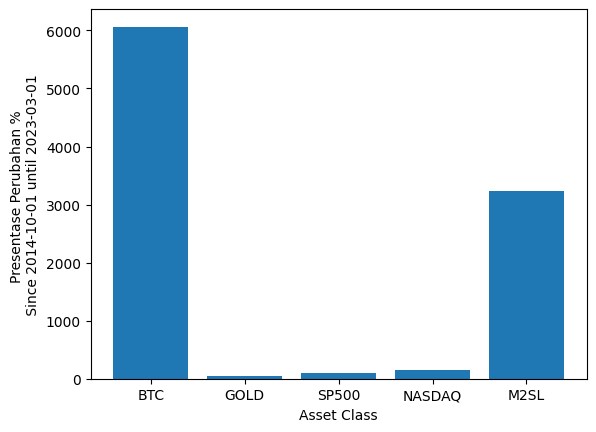

In [9]:
plt.figure(1)
plt.bar(list_Asset,nilai_perubahan)
plt.xlabel("Asset Class")
plt.ylabel("Presentase Perubahan % \n Since 2014-10-01 until 2023-03-01 ")

In [10]:
# Mencari Korelasi Antara Asset Tersebut

In [11]:
corr = df.corr()

In [12]:
corr

,BTC,Gold,S&P500,NASDAQ,M2SL
BTC,1.000000,0.766714,0.897872,0.918841,0.837029
Gold,0.766714,1.000000,0.896406,0.911007,0.945620
S&P500,0.897872,0.896406,1.000000,0.984172,0.962452
NASDAQ,0.918841,0.911007,0.984172,1.000000,0.951484
M2SL,0.837029,0.945620,0.962452,0.951484,1.000000


Text(0.5, 1.0, 'Heat-map Korelasi Silang Antar Asset')

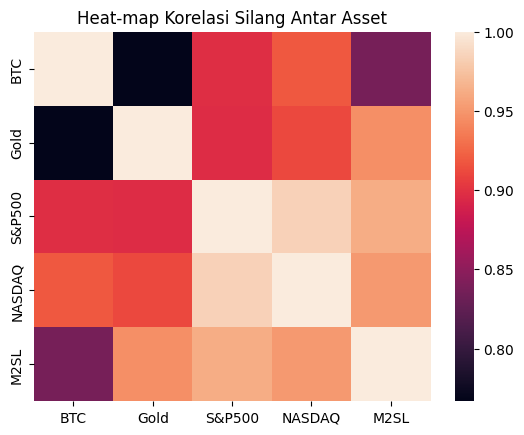

In [13]:
plt.figure(2)
sns.heatmap(corr)
plt.title("Heat-map Korelasi Silang Antar Asset")

In [14]:
# Prediksi Harga Bitcoin Menggunakan Tensorflow

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import MinMaxScaler

2023-05-08 19:01:59.984789: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
time = np.asarray(btc.index)
x_harga = btc['Adj Close'].values
min = np.min(x_harga)
max = np.max(x_harga)
x_harga -=min
x_harga /=max

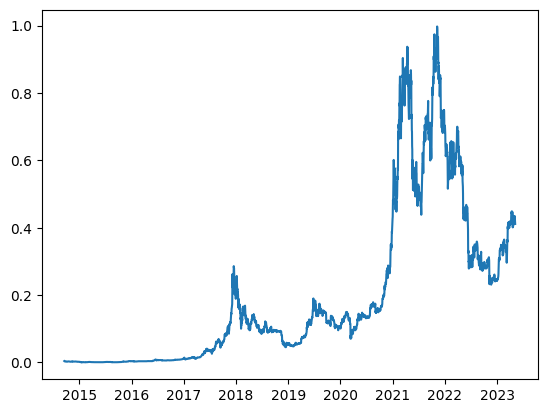

In [17]:
plt.figure(3)
plt.plot(time,x_harga)

In [18]:
# Pembagian Dataset
split_time=int(0.8*len(btc))
time_train = time[:split_time]
time_test = time[split_time:]
x_harga_train = x_harga[:split_time]
x_harga_test = x_harga[split_time:]

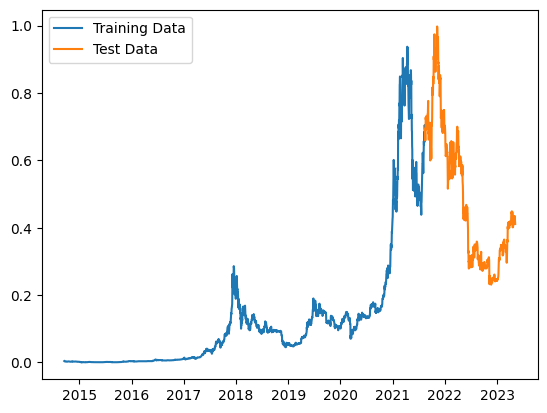

In [19]:
plt.figure(4)
plt.plot(time_train,x_harga_train,label="Training Data")
plt.plot(time_test,x_harga_test,label="Test Data")
plt.legend()

In [20]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [21]:
shuffle_buffer_size = 1000
window_size = 64
batch_size = 256

train_set = windowed_dataset(x_harga_train, window_size, batch_size, shuffle_buffer_size)
test_set = windowed_dataset(x_harga_test, window_size, batch_size, shuffle_buffer_size)

In [22]:

model = tf.keras.models.Sequential([ 
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                    input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(1),]) 


2023-05-08 19:02:07.326415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 19:02:07.328263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 19:02:07.330644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-05-08 19:02:09.024217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 19:02:09.025900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 19:02:09.027797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 2048)       8404992   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 1024)       10489856  
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 512)        2623488   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 256)        656384    
 nal)                                                   

In [24]:

optimizer = tf.keras.optimizers.RMSprop(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
history = model.fit(train_set,validation_data=test_set,epochs=10)


Epoch 1/10


2023-05-08 19:02:09.782873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2524,1]
	 [[{{node Placeholder/_0}}]]
2023-05-08 19:02:09.783414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2524,1]
	 [[{{node Placeholder/_0}}]]
2023-05-08 19:02:10.241658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

2023-05-08 19:02:11.552309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 19:02:11.554432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 19:02:11.556633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-05-08 19:02:16.125246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-05-08 19:02:16.186072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 19:02:16.187602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

2023-05-08 19:02:17.634838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 19:02:17.637592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 19:02:17.639573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

     10/Unknown - 131s 12s/step - loss: 0.0105 - mae: 0.0921

2023-05-08 19:04:22.066568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [632,1]
	 [[{{node Placeholder/_0}}]]
2023-05-08 19:04:22.066959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [632,1]
	 [[{{node Placeholder/_0}}]]
2023-05-08 19:04:22.302346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

2023-05-08 19:04:24.034207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 19:04:24.036016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 19:04:24.038497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 146s 13s/step - loss: 0.0105 - mae: 0.0921 - val_loss: 0.0084 - val_mae: 0.1156
Epoch 2/10
10/10 [==============================] - 119s 12s/step - loss: 0.0082 - mae: 0.1037 - val_loss: 0.0186 - val_mae: 0.1720
Epoch 3/10
10/10 [==============================] - 140s 14s/step - loss: 0.0027 - mae: 0.0601 - val_loss: 0.0026 - val_mae: 0.0533
Epoch 4/10
10/10 [==============================] - 143s 14s/step - loss: 0.0010 - mae: 0.0354 - val_loss: 0.0016 - val_mae: 0.0417
Epoch 5/10
10/10 [==============================] - 136s 14s/step - loss: 5.1965e-04 - mae: 0.0199 - val_loss: 0.0014 - val_mae: 0.0413
Epoch 6/10
10/10 [==============================] - 116s 12s/step - loss: 4.2383e-04 - mae: 0.0167 - val_loss: 0.0020 - val_mae: 0.0521
Epoch 7/10
10/10 [==============================] - 124s 13s/step - loss: 3.8491e-04 - mae: 0.0146 - val_loss: 0.0013 - val_mae: 0.0388
Epoch 8/10
10/10 [==============================] - 142s 14s/step - loss: 3

2023-05-08 19:46:12.942816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3156,1]
	 [[{{node Placeholder/_0}}]]
2023-05-08 19:46:12.943122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3156,1]
	 [[{{node Placeholder/_0}}]]


97/97 [==============================] - 94s 965ms/step


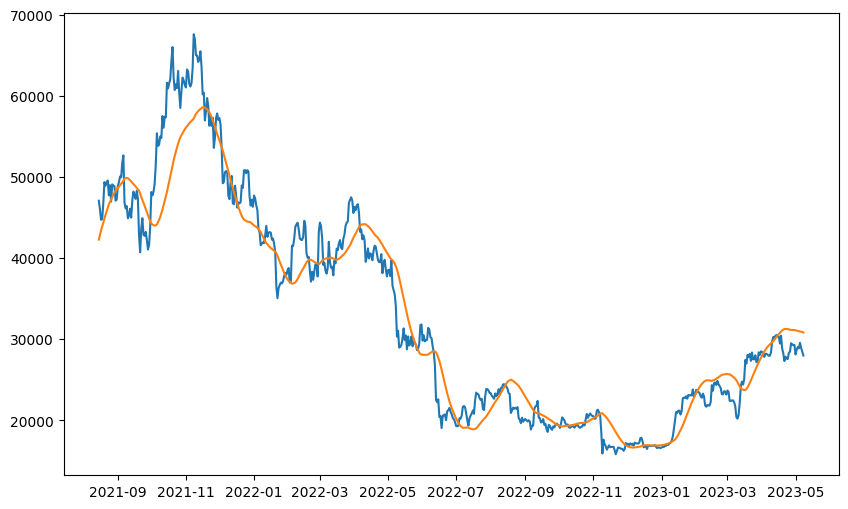

In [33]:
def model_forecast(model, series, window_size):
    # Create a TensorFlow dataset from the series
    ds = tf.data.Dataset.from_tensor_slices(series)
    # Split the dataset into windows
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    # Flatten the windows into batches
    ds = ds.flat_map(lambda w: w.batch(window_size))
    # Batch the dataset and prefetch one batch
    ds = ds.batch(32).prefetch(1)
    # Predict the next values using the model
    forecast = model.predict(ds)
    # Return the forecast
    return forecast

rnn_forecast = model_forecast(model, x_harga[:, np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time-window_size:-1, -1]
plt.figure(figsize=(10, 6))
plt.plot(time_test,x_harga_test*max+min)
plt.plot(time_test,rnn_forecast*max+min)